# Regression and Dimensionality Reduction

## 1. About the Dataset

`winequality-white` is part of the Wine Quality Dataset dataset from the UCI Machine Learning Repository. It contains data related to white variants of the Portuguese "Vinho Verde" wine (Wine Quality dataset n.d.). The `winequality-white` dataset can be used to predict the quality of white wines on a scale given chemical measures of each wine. There are `4898` observations with `11` input variables and `1` output variable. The input variables are:
- fixed acidity
- volatile acidity
- citric acid
- residual sugar
- chlorides
- free sulfur dioxide
- total sulfur dioxide
- density
- pH
- sulphates
- alcohol

There are seven classes, corresponding to seven quality scores of the wine: `3`, `4`, `5`, `6`, `7`, `8`, `9`. The number of observations for each class is not balanced.

## 2. The Approach and Questions

The goal is to train a regression model to predict the quality of white wine. 

In the training process, the dataset will be split into a training set and a test set. The training set will be further split (multiple times) into a training and validation set in a cross-validation procedure for tuning the parameters of four alternative regression algorithms:
- `RandomForestRegressor`
- `LinearRegression`
- `KNeighborsRegressor`
- `AdaBoostRegressor`

to choose the best one for training the final model.

The dimensionality reduction methods that will be used are the following:
- `Principal Component Analysis (PCA)`
- `Recursive Feature Elimination (RFE)` with estimator `svm.SVR`
- `Recursive Feature Elimination (RFE)` with estimator `LinearRegression`
- `Fast Independent Component Analysis (FastICA)`
- `SelectFromModel` with estimator `LogisticRegression`

The questions to be answered:
- How do `RandomForestRegressor`, `LinearRegression`, `KNeighborsRegressor` and `AdaBoostRegressor` algorithms compare on the `winequality-white` dataset?
- Which dimensionality reduction method is the best for each of the analysed algorithms (as determined through the grid search)?

## 3. Import Python Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

# imports necessary for dimensionality reduction
from sklearn.decomposition import FastICA, PCA
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn import svm

# regression algorithms
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# overwrite Matplotlib's default parameters by seting the style 
# by calling Seaborn's set() method
sns.set()

## 4. Load the Dataset

In [3]:
df = pd.read_csv("./winequality-white.csv")

## 5. Exploratory Data Analysis

### 5.1 Dimensions of the Dataset

In [4]:
# Print the dimensions of the dataset
df.shape

(4898, 12)

The `winequality-white` dataset has __4898__ data rows, and it contains __12__ attributes. 

### 5.2 Summary of the dataset

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


### 5.3 Quick Data Exploration

In [6]:
# Print the last 10 rows of the dataframe
df.tail(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
4888,6.8,0.220,0.36,1.20,0.052,38.0,127.0,0.99330,3.04,0.54,9.2,5
4889,4.9,0.235,0.27,11.75,0.030,34.0,118.0,0.99540,3.07,0.50,9.4,6
4890,6.1,0.340,0.29,2.20,0.036,25.0,100.0,0.98938,3.06,0.44,11.8,6
4891,5.7,0.210,0.32,0.90,0.038,38.0,121.0,0.99074,3.24,0.46,10.6,6
4892,6.5,0.230,0.38,1.30,0.032,29.0,112.0,0.99298,3.29,0.54,9.7,5
4893,6.2,0.210,0.29,1.60,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.320,0.36,8.00,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.240,0.19,1.20,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.290,0.30,1.10,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7
4897,6.0,0.210,0.38,0.80,0.020,22.0,98.0,0.98941,3.26,0.32,11.8,6


The `winequality-white` dataset contains only numerical attributes. The last attribute `quality` indicates the quality of white wine. This attribute is the primary candidate for an attribute to learn to predict from the values of the other attributes.

### 5.4 Class Distribution

The examination of the class distribution allows us to determine whether the data in the `winequality-white` dataset is balanced or not.

In [7]:
# Print the class distribution
df.groupby('quality').size()

quality
3      20
4     163
5    1457
6    2198
7     880
8     175
9       5
dtype: int64

We can determine that the number of observations for each class is not balanced.

In [8]:
df['quality'].describe()

count    4898.000000
mean        5.877909
std         0.885639
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         9.000000
Name: quality, dtype: float64

### 5.5 Quick Examination of Numerical Attributes

We can use the Pearson Correlation Matrix to examine the statistical relationship between the attributes of the `winequality-white` dataset. 

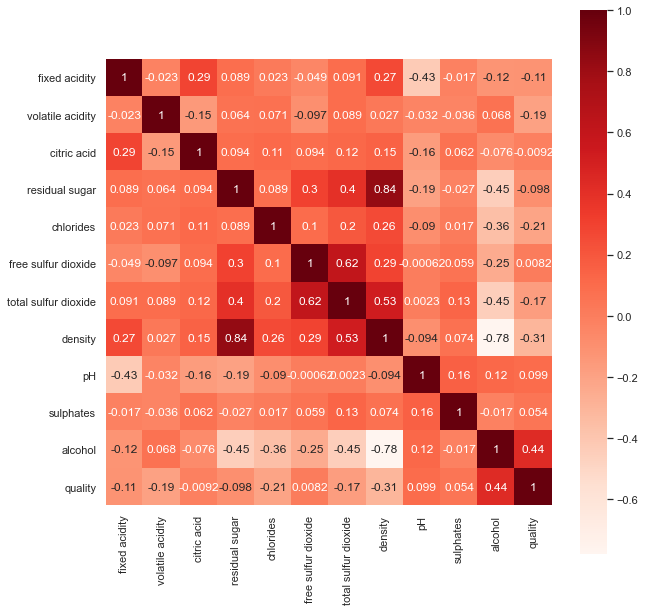

In [9]:
# adapted from
# https://towardsdatascience.com/linear-regression-and-a-quality-bottle-of-wine-b053ab768a53

# extracting variables using pandas
# features
X = df.iloc[:,:-1].values
# dependent variable
Y = df.iloc[:,-1].values

# correlation matrix
correlation = df.corr()
fig = plt.subplots(figsize=(10,10))
sns.heatmap(correlation,vmax=1,square=True,annot=True,cmap='Reds')
plt.show()

From the matrix above, we can determine that there exists a high correlation between the attributes `density` and `residual sugar` - __0.84__, and there is some correlation between the attributes `free sulfur dioxide` and `total sulfur dioxide` - __0.62__.

In general, the closer the values are to 1, the better.

### 5.6 Check for Missing Values

Next, we check for missing values.

In [10]:
# Find the number of nulls in the dataset
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

There are no missing values in the `winequality-white` dataset.

### 5.7 Check for Outliers

Next, we check the boxplots of all columns except `quality` for outliers. We will do this in four slices.

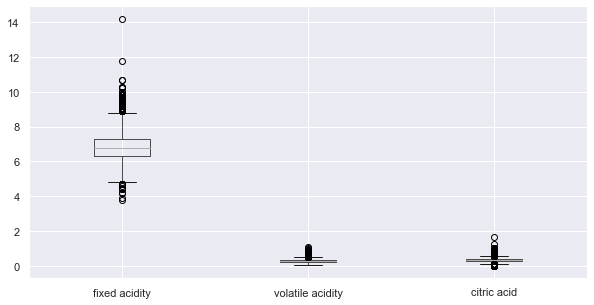

In [11]:
df.loc[:,'fixed acidity':'citric acid'].boxplot(figsize=(10,5))
plt.show()

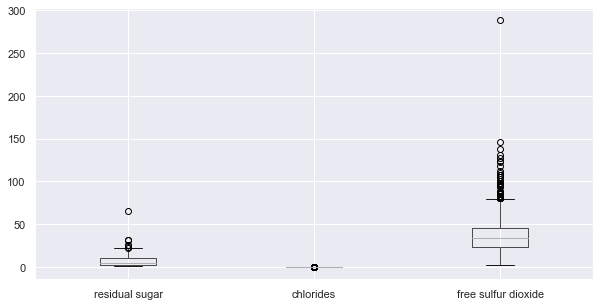

In [12]:
df.loc[:,'residual sugar':'free sulfur dioxide'].boxplot(figsize=(10,5))
plt.show()

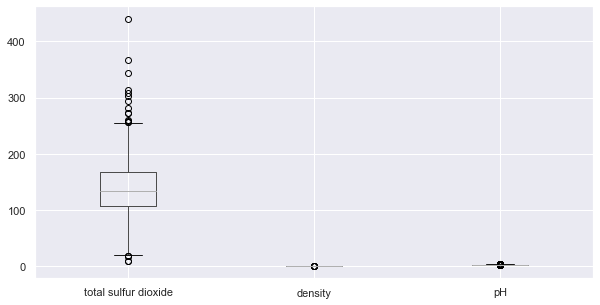

In [13]:
df.loc[:,'total sulfur dioxide':'pH'].boxplot(figsize=(10,5))
plt.show()

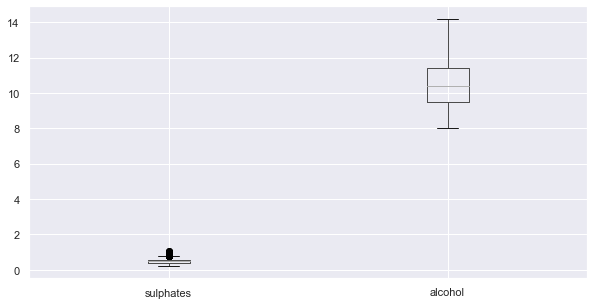

In [14]:
df.loc[:,'sulphates':'alcohol'].boxplot(figsize=(10,5))
plt.show()

The columns `fixed acidity`, `residual sugar`, `free sulfur dioxide` and `total sulfur dioxide` appear to have most prominent outliers. We will apply log transformation followed by `RobustScaler` to both of them. To all other columns (except `quality`) we will apply `StandardScaler`. 

## 6. Data Preparation

First, we need to prepare two lists of column names. The list `names_outliers` contains the names of the two columns to which we will apply log transformation followed by `RobustScaler`. The list `names_no_outliers` contains the names of all other columns (except `quality`) to which we will apply `StandardScaler`.

In [15]:
# store a list with the names of all predictors
names_all = [c for c in df if c not in ['quality']]

# define column groups with the same data preparation
names_outliers = ['fixed acidity', 'residual sugar', 'free sulfur dioxide', 'total sulfur dioxide']
names_no_outliers = list(set(names_all) - set(names_outliers))

After splitting a dataset into a training and test datasets, the names of the columns are lost. This is the reason, we stored the names of the columns in the lists above.

Next, we create a class that will be used in the preprocessing pipeline to put the names of the columns back. We need this to easily apply the different preparation strategies to the two groups of columns.

In [16]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

Then we need another class to be able to select a particular group of columns.

In [17]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

Finally, we can build the preprocessing pipeline. It first adds the column names back to a set of examples. Then it applies the two different data preparation strategies to the two groups of columns and unites them with `FeatureUnion`.

In [18]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        ))
    ])
)

Now we can separate the columns into `target` and `predictors` and split the dataset into `training` and `test` sets.

In [19]:
y = df['quality']
X = df.drop('quality', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

Although we treat `quality` as a numerical attribute, it is in fact ordinal, and we can still do a stratified split (the parameter `stratify=y`) to ensure that the distribution of wine quality is the same in both the training and the test sets.

## 7. Grid Search for Best Parameters and Best Dimensionality Reduction Method

Next, we train `RandomForestRegressor` on the training set with a range of possible parameters in order to find the best parameters by cross-validation. To do this, we will build another [main] pipeline which includes the preprocessing pipeline and `RandomForestRegressor`. We also add an element for dimensionality reduction after the preprocessing pipeline.

Here we will attempt five different dimensionality reduction methods and we will let the grid search pick the best one. These are:

- `Principal Component Analysis (PCA)`
- `Recursive Feature Elimination (RFE)` with estimator `svm.SVR`
- `Recursive Feature Elimination (RFE)` with estimator `LinearRegression`
- `Fast Independent Component Analysis (FastICA)`
- `SelectFromModel` with estimator `LogisticRegression`

__Note__: `RFE` and `SelectFromModel` are using regression algorithms for selecting the best features. These regression algorithms can be different from the regression algorithm at the end of the main pipeline.

The main pipeline will take care of separately preprocessing the training and validation sets after the training set is further split into training and validation sets in the process of cross-validation. It also applies the dimensionality reduction method separately to the two sets.

### 7.1 Random Forest Pipeline

The pipeline contains a placeholder for the dimensionality reduction method. We will treat the method as a parameter and let the grid search pick the best of the five methods.

In [20]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=10))])

We limit the parameter grid to a few options for the `max_depth` parameter of `RandomForestRegressor` and to three alternative values for the number of selected features by the dimensionality reduction method to make sure the grid search does not take too long to execute.

In [21]:
N_FEATURES_OPTIONS = [2, 6, 11]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [FastICA(algorithm='parallel', max_iter=1000)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [SelectFromModel(LogisticRegression(max_iter=1000))],
        'reduce_dim__max_features': N_FEATURES_OPTIONS
    }
]

search = GridSearchCV(pipe, param_grid, cv=10, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.410:
Best parameters:  {'reduce_dim': SelectFromModel(estimator=LogisticRegression(C=1.0, class_weight=None,
                                             dual=False, fit_intercept=True,
                                             intercept_scaling=1, l1_ratio=None,
                                             max_iter=1000, multi_class='auto',
                                             n_jobs=None, penalty='l2',
                                             random_state=None, solver='lbfgs',
                                             tol=0.0001, verbose=0,
                                             warm_start=False),
                max_features=6, norm_order=1, prefit=False, threshold=None), 'reduce_dim__max_features': 6}


The parameter `refit=True` makes the `GridSearchCV` train a `RandomForestRegressor` model on the **entire training set** with the best parameters and the best dimensionality reduction method found. This best model can then be accessed via the `.best_estimator_` attribute of the `GridSearchCV`.

Next, we repeat the same experiment but with `LinearRegression` for training a regression model.

### 7.2 Linear Regression Pipeline

The pipeline contains a placeholder for the dimensionality reduction method. We will treat the method as a parameter and let the grid search pick the best of the five methods.

In [22]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

We limit the parameter grid of `LinearRegression` to make sure the grid search does not take too long to execute.

In [23]:
N_FEATURES_OPTIONS = [2, 6, 11]
NORMALIZE_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [FastICA(algorithm='parallel', max_iter=1000)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [SelectFromModel(LogisticRegression(max_iter=1000))],
        'reduce_dim__max_features': N_FEATURES_OPTIONS
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=10, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.285:
Best parameters:  {'reduce_dim': FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=1000,
        n_components=11, random_state=None, tol=0.0001, w_init=None,
        whiten=True), 'reduce_dim__n_components': 11, 'regresson__normalize': False}


Next, we repeat the same experiment but with `KNeighborsRegressor` for training a regression model.

### 7.3 K-Nearest Neighbors (KNN) Pipeline

The pipeline contains a placeholder for the dimensionality reduction method. We will treat the method as a parameter and let the grid search pick the best of the five methods.

In [24]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', KNeighborsRegressor(n_neighbors=3))])

We limit the parameter grid of `KNeighborsRegressor` to make sure the grid search does not take too long to execute.

In [25]:
N_FEATURES_OPTIONS = [2, 6, 11]
ALGORITHM = ['auto', 'ball_tree', 'kd_tree', 'brute']

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__algorithm': ALGORITHM
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__algorithm': ALGORITHM
    },
    {
        'reduce_dim': [FastICA(algorithm='parallel', max_iter=1000)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__algorithm': ALGORITHM
    },
    {
        'reduce_dim': [SelectFromModel(LogisticRegression(max_iter=1000))],
        'reduce_dim__max_features': N_FEATURES_OPTIONS
    }
]

search = GridSearchCV(pipe, param_grid, cv=10, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
KNN_best_params = search.best_params_
KNN_best_model = search.best_estimator_

Best CV score = 0.332:
Best parameters:  {'reduce_dim': FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=1000,
        n_components=11, random_state=None, tol=0.0001, w_init=None,
        whiten=True), 'reduce_dim__n_components': 11, 'regresson__algorithm': 'auto'}


Next, we repeat the same experiment but with `AdaBoostRegressor` for training a regression model.

### 7.4 AdaBoost Pipeline

The pipeline contains a placeholder for the dimensionality reduction method. We will treat the method as a parameter and let the grid search pick the best of the five methods.

In [26]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', AdaBoostRegressor(n_estimators=10))])

We limit the parameter grid of `AdaBoostRegressor` to make sure the grid search does not take too long to execute.

In [27]:
N_FEATURES_OPTIONS = [2, 6, 11]
RANDOM_STATE = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__random_state': RANDOM_STATE
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__random_state': RANDOM_STATE
    },
    {
        'reduce_dim': [FastICA(algorithm='parallel', max_iter=1000)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__random_state': RANDOM_STATE
    },
    {
        'reduce_dim': [SelectFromModel(LogisticRegression(max_iter=1000))],
        'reduce_dim__max_features': N_FEATURES_OPTIONS
    }
]

search = GridSearchCV(pipe, param_grid, cv=10, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
AB_best_params = search.best_params_
AB_best_model = search.best_estimator_

Best CV score = 0.297:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                               normalize=False),
    n_features_to_select=6, step=1, verbose=0), 'reduce_dim__n_features_to_select': 6, 'regresson__random_state': True}


#### Conclusion

The results of the grid search suggest that `RandomForestRegressor` performs better than `LinearRegression`, `KNeighborsRegressor` and `AdaBoostRegressor`.

The cross-validation score is `1 - relative squared error`. The higher the score the more accurate the model. 

We can now further confirm this by comparing the best models on the test set.

## 8. Compare Regression Models on Test Set

Now we can evaluate the best models found by the grid search on the test dataset and compare their metrics:

- `mean squared error (MSE)`
- `mean absolute error (MAE)`
- `1-relative squared error (R2)`

to choose the best regressor for our problem.

In [28]:
# model - a trained regression model
def evaluate_model(X_test, y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

We will use the `evaluate_model` function above to evaluate the best `RandomForestRegressor`, `LinearRegression`, `KNeighborsRegressor` and `AdaBoostRegressor` models found by the grid search.


In [29]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)
KNN_mse, KNN_mae, KNN_r2 = evaluate_model(X_test, y_test, KNN_best_model)
AB_mse, AB_mae, AB_r2 = evaluate_model(X_test, y_test, AB_best_model)

We will use a Pandas `bar plot` to compare the results. 

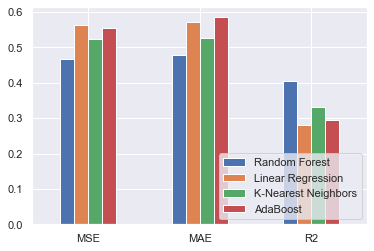

In [30]:
RF_metrics = np.array([RF_mse, RF_mae, RF_r2])
LR_metrics = np.array([LR_mse, LR_mae, LR_r2])
KNN_metrics = np.array([KNN_mse, KNN_mae, KNN_r2])
AB_metrics = np.array([AB_mse, AB_mae, AB_r2])
index = ['MSE', 'MAE', 'R2']
df_metrics = pd.DataFrame({'Random Forest': RF_metrics, 'Linear Regression': LR_metrics, 'K-Nearest Neighbors': KNN_metrics, 'AdaBoost': AB_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

#### Conclusion

This test confirms that `RandomForestRegressor` is the best regression model with the lowest `MSE` and `MAE` and the highest `R2`.

## 9. Train the Final Model

Finally, we can train a `RandomForestRegressor` model with all the data we have, assuming that the more data we have the better the model.

In [31]:
# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     RF_best_params.get('reduce_dim'),
                     RandomForestRegressor(n_estimators=10, **transform(RF_best_params, 'regresson__')))

final_model = pipe.fit(X, y)

## 10. Visualise the Difference Between the Actual and Predicted Values

We can visualise the difference between the actual values and the values predicted by the `RandomForestRegressor` model.

In [32]:
y_pred = final_model.predict(X_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.head(20)
df1

,Actual,Predicted
4510,6,6.3
2965,8,7.3
3683,6,5.9
1503,7,6.9
4014,6,6.0
4324,6,6.1
1756,5,5.1
896,6,5.8
3369,7,6.9
4862,6,6.1


## 11. Store the Model on Disk

Finally, we store the model on disk.

In [33]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

## 12. Conclusion

The four examined regression algorithms achieved the following best CV scores:
- `RandomForestRegressor` - 0.410
- `LinearRegression` - 0.285
- `KNeighborsRegressor` - 0.332
- `AdaBoostRegressor` - 0.297


The `RandomForestRegressor` algorithm, in addition to the best CV score, achieved the best results on the test set. It was the best regression model with the lowest `MSE` and `MAE`, and the highest `R2`.

The second best regression model was `KNeighborsRegressor`.


The best dimensionality reduction method for each of the analysed algorithms (as determined through the grid search) was:
- `SelectFromModel` with estimator `LogisticRegression` for the `RandomForestRegressor` algorithm
- `FastICA` for the `LinearRegression` and `KNeighborsRegressor` algorithms
- `RFE` with estimator `LinearRegression` for the `AdaBoostRegressor` algorithm

## References

*AdaBoostRegressor* (n.d.) Scikit Learn 0.22.2 documentation, available: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html [accessed 25 Apr 2020].

*FastICA* (n.d.) Scikit Learn 0.22.2 documentation, available: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html [accessed 25 Apr 2020].

*KNeighborsRegressor* (n.d.) Scikit Learn 0.22.2 documentation, available: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html [accessed 25 Apr 2020].

*LogisticRegression* (n.d.) Scikit Learn 0.22.2 documentation, available: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html [accessed 25 Apr 2020].

Rai, A. (2019) *Linear regression and a quality bottle of wine*, Towards Data Science, available: https://towardsdatascience.com/linear-regression-and-a-quality-bottle-of-wine-b053ab768a53 [accessed 25 Apr 2020].

*SelectFromModel*(n.d.) Scikit Learn 0.22.2 documentation, available: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html [accessed 25 Apr 2020].

*Wine Quality dataset* (n.d.) UCI Machine Learning Repository, available: http://archive.ics.uci.edu/ml/datasets/Wine+Quality [accessed 26 Apr 2020].